<img src="media/jupybanner-EOAFRICA+ESA.png" width="100%" alt="Banner for EO AFRICA course" />

# Exercise: Introduction to retracking exercise
**face 2 face workshop Soil Moisture and Inland Water A with Satellite Radar
Dar es Salaam, Tanzania, 19th October 2023**

*Authors: Bene Aschenneller, Roelof Rietbroek
October 2023*

## License
This notebook is provided under the following license: [CC-BY-NC-4.0](http://creativecommons.org/licenses/by-nc/4.0/)
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a>

## Introduction and goal of the Exercise

In satellite radar altimetry, the data is sent from the satellite to the ground station in form of waveforms. Waveforms describe the received energy of the reflections over time. In this exercise you will have a look at waveforms over Lake Tana in Ethiopia and learn how to compute the range (the distance between the satellite and the Earth's surface) with retracking. You find **ToDo**-markers among the notebook with questions and code parts to fill in.

### Links and further reading
* [The shared folder on the Innovation lab ` see shared/F2F-Dar-es-Salaam_Oct2023`](https://f2f-training.vre.innovation-lab.eoafrica-rd.org)
* [Jason-3 products handbook](https://www.aviso.altimetry.fr/fileadmin/documents/data/tools/hdbk_j3.pdf)
* [Deng (2002), Estimation of Contamination of ERS-2 and POSEIDON Satellite Radar Altimetry Close to the Coasts of Australia](http://www.tandfonline.com/doi/abs/10.1080/01490410214990)
* [Vignudelli (2011), Coastal Altimetry](https://ut.on.worldcat.org/search/detail/701369218?queryString=coastal%20altimetry&clusterResults=true&groupVariantRecords=false)
* [Cretaux (2022), Inland Water Altimetry: Technological Progress and Applications](https://link.springer.com/chapter/10.1007/978-3-031-08262-7_6)

## Step 1: Loading the necessary modules

In [ ]:
import xarray as xr
import numpy as np

# plotting
import matplotlib.pyplot as plt
import cartopy
from cartopy.feature import LAKES
# import cartopy.crs as ccrs
import glob
import os
%matplotlib inline

# Step 1.1 Get the right file path to the Jason-3 data

In [ ]:
cycle=34
passnum=94
prodversion='f'

# While on the EO Africa Innovation platform one can use this
eodatapath=f"/home/eoafrica/eodata/Jason-3/GDR/S-GDR/cycle_{cycle:03d}/JA3_GPS_2P{prodversion}P{cycle:03d}_{passnum:03d}*/*nc"

# when working locally change to
# eodatapath=f"../data/JA3_GPS_2P{prodversion}P{cycle:03d}_{passnum:03d}*nc"

#search for the correct netcdf file
jason3filepath=glob.glob(eodatapath)[0]
print(jason3filepath)

## Step 2.1: Load the dataset und reduce it to the study area
This .nc-file (NetCDF format) is organized in groups to separate the fields in 1 Hz and 20 Hz resolution. Working with groups in xarray is (to this date) not possible, we therefore end up with a lot of code (sorry) and two Datasets `data_20` and `data_01`.

In [ ]:
# load the groups from the netcdf file
data_coords = xr.open_dataset(jason3filepath) # global coordinates of the netcdf file
data_20 = xr.open_dataset(jason3filepath, group='/data_20') # more corrections are in data_01
data_20_ku = xr.open_dataset(jason3filepath, group='/data_20/ku')
data_01 = xr.open_dataset(jason3filepath, group='/data_01')
data_01_ku = xr.open_dataset(jason3filepath, group='/data_01/ku')

# put the groups together to one xarray Dataset for each frequency
data_20 = data_coords.merge(data_20)
data_20 = data_20.merge(data_20_ku)

data_01 = data_coords.merge(data_01)
data_01 = data_01.merge(data_01_ku)

# reduce the dataset to the study area
bnds_lat = (12.35, 11.558) # Lake Tana
idx_20 = np.where((data_20.latitude < bnds_lat[0]) & (data_20.latitude > bnds_lat[1]))[0]
data_20 = data_20.isel(time=idx_20)
idx_01 = np.where((data_01.latitude < bnds_lat[0]) & (data_01.latitude > bnds_lat[1]))[0]
data_01 = data_01.isel(time=idx_01)

# Show dimensions, coordinates, variables and attributes of the two Datasets
display(data_20)
display(data_01)

**ToDo**: Have a look at both datasets.
- What are the differences in dimensions and coordinates?
- What could be meant by 'samples'?
- What is the name of the mission?
- Which time period is covered by this dataset?
- For the brave-hearted: Expand the section with 'Data variables' and read a few of the data attributes describing each field.

## Step 2.2: Define functions

#### Helper functions

In [ ]:
def find_nearest(sample, data):
    # find the index of the datapoint that is closest to the requested sample value
    diffs = data - sample
    nearest = min(abs(diffs))
    eps = 0.001
    idx = np.where((diffs <= nearest + eps) & (diffs >= nearest - eps))[0][0]
    return idx

In [ ]:
def rms(ts):
    return round(np.sqrt(np.nanmean(ts **2)),3)

def std(ts): # Variation in one timeseries
    err = ts - np.nanmean(ts)
    return rms(err)

#### Plot functions

In [ ]:
 def plot_altimetry_tracks(lon, lat, title, cb_label=None, value=None, extent=None, cross=None):
    """
    lon: list or array
    lat: list or array
    save: bool
        True: saves the plot as .png
    value : tuple of arrays
        Vector with same length as lon and lat, adds colour-coding
    title: string
    label: string
    extent: dictionary in the form of {'lon_min': x.x, 'lon_max': x.x, 'lat_min': x.x, 'lat_max': x.x}
    """
    fig = plt.figure(figsize=(18,8))
    #plt.ticklabel_format(useOffset=False) # want to see the real numbers on the y-axes, not something *8e5
    
    pc=cartopy.crs.PlateCarree()
    ax = plt.axes(projection=pc)
    ax.add_feature(LAKES, edgecolor = 'darkgray', facecolor = "lightblue", zorder=1)
    ax.gridlines(draw_labels=True, crs=pc)
    
    if extent != None:
        wnse = list(extent.values())
        ax.set_extent(wnse, crs=pc)
    
    if value is None:
        plot = ax.plot(lon, lat, marker='+', ls="")
    else:
        plot = plt.scatter(lon, lat, c=value, marker='+')
        cbar = plt.colorbar(plot, orientation="vertical")
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(label=cb_label, size=20)
    
    if cross != None:
        for lats in cross:
            idx = find_nearest(lats, lat)
            ax.plot(lon[idx], lat[idx], 'xr', markersize=12)
                
    plt.title(title,fontsize=20)    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

In [ ]:
def plot_waveforms(data, lat):
    ylim = 340
    fig, axs = plt.subplots(nrows=len(lat), ncols=1, figsize=(10,len(lat)*2.3))
    for i, latitude in enumerate(lat):
        # find the index of the latitude that is closest to the requested value:
        idx = find_nearest(latitude, data.latitude)
        axs[i].plot(data.samples, data.power_waveform[idx,:], '.-')
        axs[i].set_title('latitude = ' + str(latitude))
        axs[i].set_ylim(0, ylim)
        axs[i].tick_params(axis='both', which ='major', labelsize=13)
        
    fig.tight_layout()
    fig.suptitle("Waveforms", fontsize=20, x=0.53, y=1.01)
    fig.supxlabel('Gates', fontsize=18)
    fig.supylabel('Power', fontsize=18, x=-0.02)    

In [ ]:
def plot_single_waveform(data, lat, lep=None, tracking_gate=None, A=None, COG=None):
    fig, ax = plt.subplots(figsize=(10, 3.5), tight_layout=True)
    # find the index of the latitude that is closest to the requested value:
    idx = find_nearest(lat, data.latitude)
    ax.plot(data.samples, data.power_waveform[idx,:], '.-')
    ax.set_title(("Waveform at latitude " + str(lat)), fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_xlabel('Gates', fontsize=18)
    ax.set_ylabel('Power', fontsize=18)
    
    if lep != None:
        plt.vlines(lep, -5, max(data.power_waveform[idx,:]), 'r', label='LEP')

    if tracking_gate != None:
        plt.vlines(tracking_gate, -5, max(data.power_waveform[idx,:]), 'black', label='tracking gate')
        
    if A != None:
        plt.hlines(A, min(data.samples), max(data.samples), 'g', label='Amplitude')
        
    if COG != None:
        plt.plot(COG, 0.5*A, 'o', color='black', markersize=8, label='COG')

    ax.legend(loc='lower right')    

## Step 3: Have a look at the waveforms along the track

**ToDo**:
- Use the function `plot_altimetry_tracks` to plot a map of the track. 
- With the help of this map, define a list of latitudes `lat = [lat1, lat2, ...]` along the track where you would like to see the corresponding waveforms.
- Plot these waveforms using the function `plot_waveforms`.
- Also add the list of latitudes as the cross-parameter in `plot_altimetry_tracks`. This will show you the location of your waveforms on the map.

*Coding tips*:
- To call a function, you type the name of the function and add the required parameters in brackets.
- Some parameters have a default value assigned in the function definition, in this case e.g. `cross=None` means that you don't have to pass this parameter for the function to work.
- For `extent` you can use `extent = {'lon_min': 36.965, 'lon_max': 37.700, 'lat_min': bnds_lat[1], 'lat_max': bnds_lat[0]+0.1}`.

**Terminology**:
- Waveform: Reflected power over time
- Gates: A timestep, for the Jason missions: 1 gate = 3.125 ns. Sometimes also called 'bins'.

**Questions**:
- How do the waveforms change along the track?
- Can you identify similar characteristics in the shapes of different waveforms?
- Can you see any relation between the waveform shape and the distance to land?

In [ ]:
extent = {'lon_min': 36.965, 'lon_max': 37.700, 'lat_min': bnds_lat[1], 'lat_max': bnds_lat[0]+0.1}
# map (without waveform positions)
# plot_altimetry_tracks(data_20.longitude, data_20.latitude, extent=extent)

# lat: list of latitudes where to plot waveforms
lat = [12.3, 12.25, 12.15, 12.08, 12.00, 11.85]

# map (with waveform positions)
plot_altimetry_tracks(data_20.longitude, data_20.latitude, title='Jason-3 track over Lake Tana, 13.01.2017',extent=extent, cross=lat)
plot_waveforms(data_20, lat)

## Step 4: Implement the OCOG retracker
**Theory**
- A retracker is an algorithm to retrieve parameters like the range (also wave height or wind speed, but here we focus on the range) from the waveform.
- Retracking can be done by fitting a model to a waveform or by computing the waveform statistics. There is a wide variety of retracking algorithms.
- The most famous retracker is the Brown model. It is based on physics and works well in most cases when there is no land contaminating the footprint.
- The Offset Centre of Gravity Retracker (OCOG) is an empirical retracker based on statistics. It estimates a rectangle with amplitude (A), width (W) and center of gravity (COG). Based on this rectangle, the position (in terms of gates) of the leading edge (the first rise of power in the waveform) is computed.

**Schematic diagram of the OCOG retracker from Vignudelli (2011):**



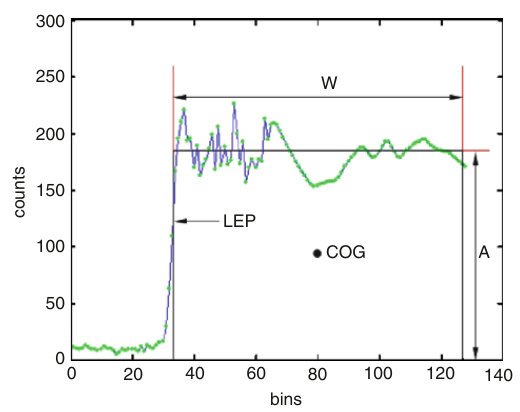
     

**ToDo**:
- Choose a waveform you would like to retrack and assign this value to the variable `lat_single` in the cell below.
- Compute amplitude, width, center of gravity and leading edge position.

*Coding tips*
- P in the formulae below is the power that is stored in variable `wf` in the next cell.
- "x to the power of a" translates in python to `x**a`
- `wf` is still a xarray Dataset, it therefore also has the xarray function .sum()

In [ ]:
lat_single = 12.15
idx_wf = find_nearest(lat_single, data_20.latitude)
wf = data_20.power_waveform[idx_wf, :]

#### 1. Amplitude
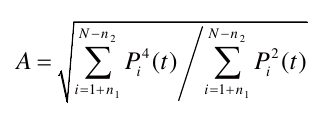

In [ ]:
A = np.sqrt((wf**4).sum() / (wf**2).sum())
print(A.values)

#### 2. Width
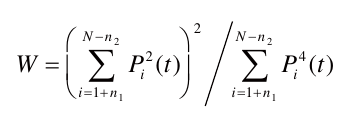

In [ ]:
W = ((wf**2).sum())**2 / (wf**4).sum()
print(W.values)

#### 3. Waveform Center of Gravity
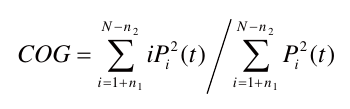

In [ ]:
sum1 = 0
for i, value in enumerate(wf):
    sum1 = sum1 + (i * (value**2))
    
COG = sum1 / (wf**2).sum()
print(COG.values)

#### 4. Leading Edge Position
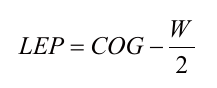

In [ ]:
LEP = COG - W/2
print(LEP.values)

#### 5. Compute range correction
**Theory**
- The radar pulse has a rather long way (~1340 km) to travel to the surface and back. The time covered by the waveform is only the short period of reflection at the surface.
- The task of the onboard tracker is to estimate the approximate distance to the surface for each point in order to determine when the recording of the waveform should start so that all of the interesting signal is received. This process is sometimes called "positioning the tracker window".
- We know that this estimate covers the range until a fixed reference, the "tracking gate". For the Jason missions, the tracking gate is always gate 32.5. The input file contains the values for the tracker range, this is the range from emitting the pulse at the satellite to the tracking gate.
- The results of retracking is a correction to this tracking range. In the case of the OCOG retracker, the distance between the LEP and the tracking gate is the correction for the range.
- When the LEP lies before the tracking gate, the correction is negative. When the LEP lies after the tracking gate, the correction is positive.

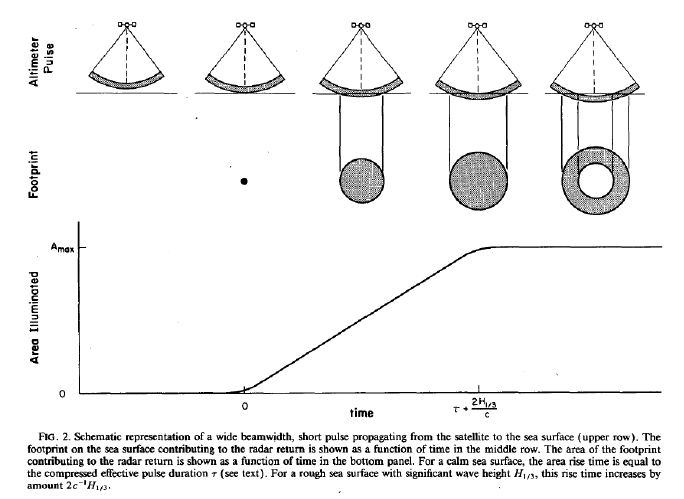

Figure from Chelton et al. 1989, Pulse Compression and Sea Level Tracking in Satellite Altimetry

**ToDo**
- Compute the difference (in 'unit' gates) between the LEP and the tracking gate.
- You already know the length of one gate (3.125 ns).
- With these two values and the speed of light, compute the range correction.


In [ ]:
# assume that radiowaves travel with speed of light
sod = 299792458 # [m/s], speed of light

# nominal tracking gate for Jason-3
tracking_gate = 32.5
gate_diff = LEP - tracking_gate

range_correction = gate_diff * (10**-9) * sod
print('Range correction from retracking:', range_correction.values, 'm')

In [ ]:
# Plot the main outcomes of the OCOG retracker
plot_single_waveform(data_20, lat_single, lep=LEP, tracking_gate=tracking_gate, A=A, COG=COG)

## Step 5: Compute the total range
The total range from the satellite to the surface results from adding the range correction to the tracker range.

**ToDo**
- In the input file (`data_20`), how many tracker ranges do you find? What are their differences?
- Choose a tracker range and exxtract the waveform using `idx_wf`.
- Add the range correction to the tracker range to get the total range.

In [ ]:
# without corrections
data_20.tracker_range_diode[idx_wf]

In [ ]:
data_20.tracker_range_calibrated[idx_wf]
# corrections included:
# - Distance antenna-COG (/data_01/range_cor_cog)
# - USO drift correction (/data_01/range_cor_uso)
# - internal path correction (/data_01/ku/range_cor_internal_path)

In [ ]:
range_total = (data_20.tracker_range_calibrated[idx_wf] + range_correction).values
range_total

## Step 6: Validate the resulting range
**ToDo**
- How many solutions for the total range do you find in the input file (`data_20`)?
- How do their results differ?

In [ ]:
data_20.range_ocean[idx_wf]
# corrections included:
# - Distance antenna-COG (/data_01/range_cor_cog)
# - USO drift correction (/data_01/range_cor_uso)
# - internal path correction (/data_01/ku/range_cor_internal_path)
# - Doppler correction (/data_01/ku/range_cor_doppler)
# - modeled instrumental errors correction (/data_01/ku/range_cor_ocean_model_instr)
# - system bias

In [ ]:
data_20.range_ocean_mle3[idx_wf]
# corrections included:
# - Distance antenna-COG (/data_01/range_cor_cog)
# - USO drift correction (/data_01/range_cor_uso)
# - internal path correction (/data_01/ku/range_cor_internal_path)
# - Doppler correction (/data_01/ku/range_cor_doppler)
# - modeled instrumental errors correction (/data_01/ku/range_cor_ocean_model_instr)
# - system bias

In [ ]:
data_20.range_adaptive[idx_wf]
# corrections included:
# - Distance antenna-COG (/data_01/range_cor_cog)
# - USO drift correction (/data_01/range_cor_uso)
# - internal path correction (/data_01/ku/range_cor_internal_path)
# - Doppler correction (/data_01/ku/range_cor_doppler)
# - system bias

In [ ]:
data_20.range_ocog[idx_wf]
# corrections included:
# - Distance antenna-COG (/data_01/range_cor_cog)
# - USO drift correction (/data_01/range_cor_uso)
# - internal path correction (/data_01/ku/range_cor_internal_path)
# - Doppler correction (/data_01/ku/range_cor_doppler)
# - system bias

**Corrections**

The ranges in the input file have already some corrections included. (For now, don't worry too much about the corrections, we will come to them soon.) To make these ranges comparable to our range we have to add the same corrections:

In [ ]:
# Interpolate corrections (linearly) from 1 Hz resolution to 20 Hz
range_cor_cog_20 = np.interp(data_20.time, data_01.time, data_01.range_cor_cog)
range_cor_uso_20 = np.interp(data_20.time, data_01.time, data_01.range_cor_uso)
range_cor_internal_path_20 = np.interp(data_20.time, data_01.time, data_01.range_cor_internal_path)
range_cor_doppler_20 = np.interp(data_20.time, data_01.time, data_01.range_cor_doppler)
range_cor_ocean_model_instr_20 = np.interp(data_20.time, data_01.time, data_01.range_cor_ocean_model_instr)

In [ ]:
# For comparison with range_ocog and range_adaptive, add the Doppler correction:
range_total_corr1 = range_total + range_cor_doppler_20[idx_wf]
range_total_corr1

In [ ]:
# For comparison with range_ocean and range_ocean_mle3, add the Doppler correction and the modelled instrumental correction:
range_total_corr2 = range_total + range_cor_doppler_20[idx_wf] + range_cor_ocean_model_instr_20[idx_wf]
range_total_corr2

## Step 7: Threshold retracker
- As the results from the OCOG retracker did not perform too well in comparison with the given values from the input file, we will try another empirical retracker.
- The threshold retracker uses the amplitude computed during the OCOG retracker. It defines the correction slightly different: Instead of the difference between the LEP and the tracking gate, it takes the difference between the gate where e.g. 50% of the amplitude is reached and the tracking gate as the range correction.
- Which percentage of the amplitude is chosen is slightly arbitrary, meaning that people simply made a lot of experiments and found out that e.g. 50% works well for very scattered surfaces and lower percentages work well for ice (because the pulse goes through the first layers of ice).
- Did you notice the description '(ice retracking)' in the attributes of `range-ocog`? According to a colleague this is a 30%-threshold retracker, instead of the original OCOG retracker. Yes, it would be nice of data providers to describe the fields a bit less ambiguous...

**ToDo**
- Choose a threshold.
- Compute the corresponding threshold energy as a portion of the amplitude.
- Find the corresponding gate with linear interpolation (given).
- Then proceed as above only using the new found threshold gate instead of the LEP to compute the range correction and the total range.

In [ ]:
# define threshold
q = 0.3
# threshold energy
T = q * A.values

In [ ]:
# Find the corresponding gate with linear interpolation.
# candidates for the index before first occurrence of q*A
idx_cands = np.where(wf < T)[0]

# only keep indices before the very first occurrence (in case energy later falls below q*A)
idx_before_first_occ = []
eps=2
for i in range(1, len(idx_cands)):
    if wf[idx_cands[i-1]] < (wf[idx_cands[i]] + eps):
        idx_before_first_occ.append(idx_cands[i])
    else:
        break
idx_before = idx_before_first_occ[-1]
idx_after = idx_before + 1

# assuming a linear increase of power between these two points:
ratio_energy = wf[idx_before] / wf[idx_after]

gate_threshold = idx_after - ratio_energy

print(gate_threshold.values)

In [ ]:
gate_diff_threshold = gate_threshold - tracking_gate
range_correction_threshold = gate_diff_threshold * (10**-9) * sod

In [ ]:
range_total_threshold = (data_20.tracker_range_calibrated[idx_wf] + range_correction_threshold).values
range_total_threshold

In [ ]:
# For comparison with range_ocog and range_adaptive
range_total_threshold_corr1 = range_total_threshold + range_cor_doppler_20[idx_wf]
range_total_threshold_corr1

In [ ]:
# For comparison with range_ocean and range_ocean_mle3
range_total_threshold_corr2 = range_total_threshold + range_cor_doppler_20[idx_wf] + range_cor_ocean_model_instr_20[idx_wf]
range_total_threshold_corr2

**ToDo**
- Choose another waveform and do the computation again (to save time, in the menu: Run -> Run selected cell and all below)

## Step 8: Add corrections
- After retrieving the range from retracking the waveforms, it has to be corrected for a variety of effects.
- Because looking at the full track is a bit more interesting than only one point, we will continue to work with one of the solutions for the range given in the input file (range_adaptive). (The adaptive retracker is described in [Thibaut et al. 2021](https://ieeexplore.ieee.org/abstract/document/9553647)). Just be aware that this is not what one would usually do for inland waters. 

In [ ]:
extent = {'lon_min': 36.965, 'lon_max': 37.700, 'lat_min': bnds_lat[1], 'lat_max': bnds_lat[0]+0.1}
plot_altimetry_tracks(data_20.longitude, data_20.latitude, title='Ranges from adaptive retracker',\
        cb_label='range [m]', value=data_20.range_adaptive, extent=extent)

**Possible corrections to take into account are:**
- "Ocean" tides (water body tides)
- Load tides
- Solid Earth tides
- Pole tides
- Wet atmospheric correction
- Dry tropospheric correction
- Ionospheric correction
- Instrumental corrections (are in this case already included in the given ranges)
- Inverse barometer
- Sea state bias
- High frequency fluctuations of the sea surface

**ToDo**
- Find the right corrections in the input dataset (`data_01`).
- Examine the approximate magnitude of each correction to get a feeling on how much influence they have.
- Interpolate the corrections given in 1 Hz resolution to the 20 Hz resolution of the ranges.
- Find the altitude in `data_20`.
- Put everything together: Corrected lake level = Altitude - Range + Corrections.

**Questions**
- The list of corrections above is inspired by ocean altimetry. Do you think that all these corrections are also useful/required for altimetry over lakes?
- The corrections that come with the Jason-3 waveforms in the input dataset were developed for ocean applications. On a scale from 1 (very bad) to 5 (very good), is that really a good idea?
    - For some inspiration:
        - [Fernandes et al. (2014), Atmospheric Corrections for Altimetry Studies over Inland Water](https://www.mdpi.com/2072-4292/6/6/4952)
        - [Kittel et al. (2021), Sentinel-3 radar altimetry for river monitoring – a catchment-scale evaluation of satellite water surface elevation from Sentinel-3A and Sentinel-3B](https://hess.copernicus.org/articles/25/333/2021/)
        - ...


In [ ]:
# Magnitudes of corrections
print("Water body tides:", data_01.ocean_tide_fes.mean().values, "+-", std(data_01.ocean_tide_fes), "m")
print("Load tides:", data_01.load_tide_fes.mean().values, "+-", std(data_01.load_tide_fes), "m")
print("Solid Earth tides:", data_01.solid_earth_tide.mean().values, "+-", std(data_01.solid_earth_tide), "m")
print("Pole tides:", data_01.pole_tide.mean().values, "+-", std(data_01.pole_tide), "m")
print("Wet tropospheric correction:", data_01.model_wet_tropo_cor_measurement_altitude.mean().values, "+-", std(data_01.model_wet_tropo_cor_measurement_altitude), "m")
print("Dry tropospheric correction:", data_01.model_dry_tropo_cor_measurement_altitude.mean().values, "+-", std(data_01.model_dry_tropo_cor_measurement_altitude), "m")
print("Ionospheric correction:", data_01.iono_cor_alt_mle3.mean().values, "+-", std(data_01.iono_cor_alt_mle3), "m")
print("High frequency fluctuations + Inverse barometer:", data_01.dac.mean().values, "+-", std(data_01.dac), "m")
print("Sea state bias:", data_01.sea_state_bias.mean().values, "+-", std(data_01.sea_state_bias), "m")

In [ ]:
# Interpolate the 1 Hz corrections to the 20 Hz dataset
ocean_tide_fes_20 = np.interp(data_20.time, data_01.time, data_01.ocean_tide_fes)
load_tide_fes_20 = np.interp(data_20.time, data_01.time, data_01.load_tide_fes)
solid_earth_tide_20 = np.interp(data_20.time, data_01.time, data_01.solid_earth_tide)
pole_tide_20 = np.interp(data_20.time, data_01.time, data_01.pole_tide)
model_wet_tropo_cor_measurement_altitude_20 = np.interp(data_20.time, data_01.time, data_01.model_wet_tropo_cor_measurement_altitude)
model_dry_tropo_cor_measurement_altitude_20 = np.interp(data_20.time, data_01.time, data_01.model_dry_tropo_cor_measurement_altitude)
iono_cor_alt_20 = np.interp(data_20.time, data_01.time, data_01.iono_cor_alt_mle3)
dac_20 = np.interp(data_20.time, data_01.time, data_01.dac)
sea_state_bias_mle3_20 = np.interp(data_20.time, data_01.time, data_01.sea_state_bias_mle3)

In [ ]:
# Compute the lake surface height above ellipsoide
h_ell = data_20.altitude - data_20.range_ocean \
                + ocean_tide_fes_20 \
                + load_tide_fes_20 \
                + solid_earth_tide_20 \
                + pole_tide_20 \
                + model_wet_tropo_cor_measurement_altitude_20 \
                + model_dry_tropo_cor_measurement_altitude_20 \
                + iono_cor_alt_20 + dac_20 + sea_state_bias_mle3_20

In [ ]:
plot_altimetry_tracks(h_ell.longitude, h_ell.latitude, title='Corrected lake levels',\
        cb_label='height over ellipsoid [m]', value=h_ell, extent=extent)

**On choosing "the right" correction**
- You probably saw that for each correction there are several possibilities given in the input file.
- Similar as with the retracked range, it might even be useful to use specialized products instead.
- We also lost a significant portion of the track due to the ionospheric correction. There are 9 different ones and the one applied here is already the one with the least NaN-values...
- In a real-life application we would now search the existing knowledge to find a better solution (if there is one, the research is pretty on-going).